# Anyone AI

# Project III - Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all together. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. The competition finished 4 years ago, so you will find a lot of blog posts and code written for it, we encourage you to read everything you can about it.

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

1- Login to Kaggle (if you don't have an account you'll have to register to get it) and download the [complete dataset](https://www.kaggle.com/competitions/home-credit-default-risk/data). Read the information about the data. What does a row in the main file represent? What does the target variable means?

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
!pip install lightgbm
import lightgbm as lgb

In [4]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [5]:
# ! pip install -q kaggle

# k = {"username":"fede6590", "key":"3c6791b7a9282d0935f6f072e32f6cfa"}
# with open('kaggle.json', 'w') as fp:
#     json.dump(k, fp)
# # !mkdir ~/.kaggle
# # !cp kaggle.json ~/.kaggle/
# # !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c home-credit-default-risk
# !mkdir home-credit-default-risk
# !unzip home-credit-default-risk.zip -d home-credit-default-risk

In [6]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AnyoneAI - Sprint 3/Project/application_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AnyoneAI - Sprint 3/Project/application_test.csv")

### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but you need to make sure you understand the datasets properties before starting working on it, so we'll do exploratory data analysis for the main files

**Dataset Basics**

1- Show the shape of the training and test datasets.

In [7]:
print(f"Shape of the training dataset: {df_train.shape}")
print(f"Shape of the test dataset: {df_test.shape}")

Shape of the training dataset: (307511, 122)
Shape of the test dataset: (48744, 121)


2- List all columns in the train dataset

In [8]:
list(df_train)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

3- Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [9]:
display(df_train.head())
df_train.head().T

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_MON,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_QRT,0.0,0.0,0.0,NaN,0.0


4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

Total value count:
0    282686
1     24825
Name: TARGET, dtype: int64

Percentage of each value:
0    0.919271
1    0.080729
Name: TARGET, dtype: float64


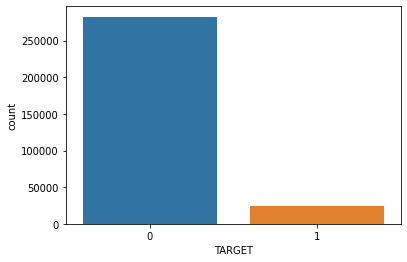

In [10]:
sns.countplot(data=df_train, x="TARGET")
print(f"Total value count:\n{df_train['TARGET'].value_counts()}\n")
print(f"Percentage of each value:\n{df_train['TARGET'].value_counts(normalize=True)}")

5- Show the number of columns of each data type

In [11]:
df_train.columns.to_series().groupby(df_train.dtypes).count()

int64      41
float64    65
object     16
dtype: int64

6- For categorical variables, show the number of distinct values in each column (number of labels)

In [12]:
feat_train = df_train.drop("SK_ID_CURR", axis=1)
feat_test = df_test.drop("SK_ID_CURR", axis=1)

print("CATEGORICAL VARIABLES IN TRAIN DATASET (TYPE OBJECT):\n")
for col in feat_train:
    if feat_train[col].dtype == "object":
        print(f"{col} feature contains {len(feat_train[col].unique())} labels")

print("\n")

print("CATEGORICAL VARIABLES IN TEST DATASET (TYPE OBJECT):\n")
for col in feat_test:
    if feat_test[col].dtype == "object":
        print(f"{col} feature contains {len(feat_test[col].unique())} labels")

CATEGORICAL VARIABLES IN TRAIN DATASET (TYPE OBJECT):

NAME_CONTRACT_TYPE feature contains 2 labels
CODE_GENDER feature contains 3 labels
FLAG_OWN_CAR feature contains 2 labels
FLAG_OWN_REALTY feature contains 2 labels
NAME_TYPE_SUITE feature contains 8 labels
NAME_INCOME_TYPE feature contains 8 labels
NAME_EDUCATION_TYPE feature contains 5 labels
NAME_FAMILY_STATUS feature contains 6 labels
NAME_HOUSING_TYPE feature contains 6 labels
OCCUPATION_TYPE feature contains 19 labels
WEEKDAY_APPR_PROCESS_START feature contains 7 labels
ORGANIZATION_TYPE feature contains 58 labels
FONDKAPREMONT_MODE feature contains 5 labels
HOUSETYPE_MODE feature contains 4 labels
WALLSMATERIAL_MODE feature contains 8 labels
EMERGENCYSTATE_MODE feature contains 3 labels


CATEGORICAL VARIABLES IN TEST DATASET (TYPE OBJECT):

NAME_CONTRACT_TYPE feature contains 2 labels
CODE_GENDER feature contains 2 labels
FLAG_OWN_CAR feature contains 2 labels
FLAG_OWN_REALTY feature contains 2 labels
NAME_TYPE_SUITE feature

We see the train dataset contains equals or more labels than the test dataset. We can asume in this case, there will be no problems for the encoding process.

7- Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [13]:
print("Missing data percentage (sorted) per features:")
(df_train.isna().sum() / df_train.shape[0]* 100).sort_values(ascending=False).head(20)

Missing data percentage (sorted) per features:


COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
FLOORSMIN_AVG               67.848630
FLOORSMIN_MODE              67.848630
FLOORSMIN_MEDI              67.848630
YEARS_BUILD_MEDI            66.497784
YEARS_BUILD_MODE            66.497784
YEARS_BUILD_AVG             66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_MEDI               59.376738
LANDAREA_MODE               59.376738
LANDAREA_AVG                59.376738
dtype: float64

**Analyzing distribution of variables**

In [14]:
sns.set(rc={'figure.figsize': (18, 6)})

1- Show the distribution of credit amounts

Text(0.5, 1.0, 'Distribution of credit amounts (in Millions)')

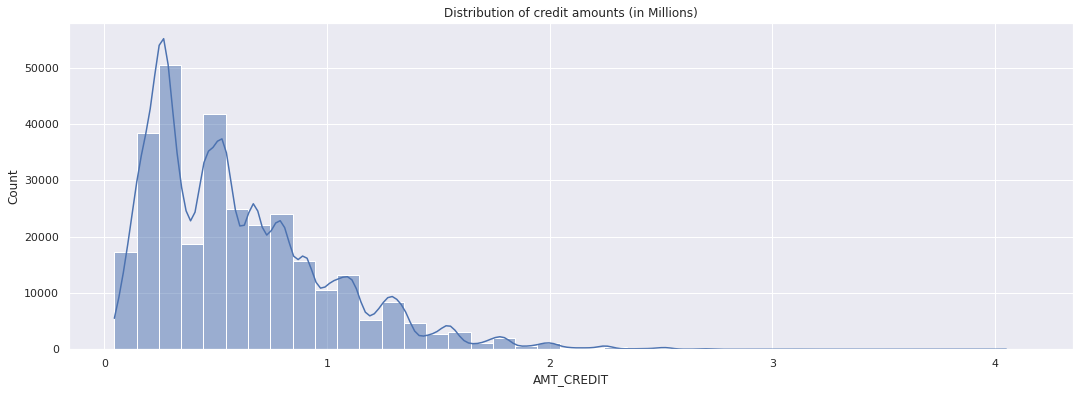

In [15]:
sns.histplot(data=(df_train["AMT_CREDIT"] / 1000000), kde=True, binwidth=0.1).set_title("Distribution of credit amounts (in Millions)")

2- Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

Total counts for each education level category:
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64



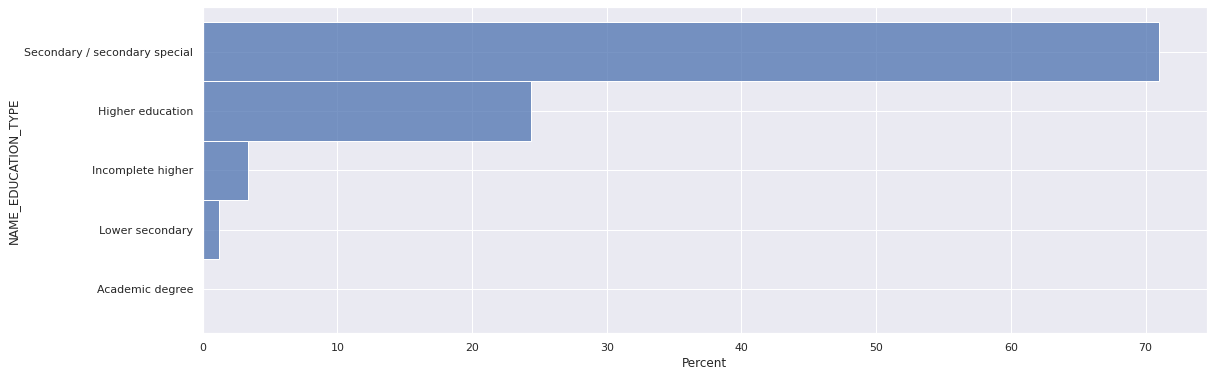

In [16]:
edu_tot_count = df_train["NAME_EDUCATION_TYPE"].value_counts()
print(f"Total counts for each education level category:\n{edu_tot_count}\n")

sns.histplot(y=df_train["NAME_EDUCATION_TYPE"], stat="percent")

3- Plot the distribution of ocupation of the loan applicants

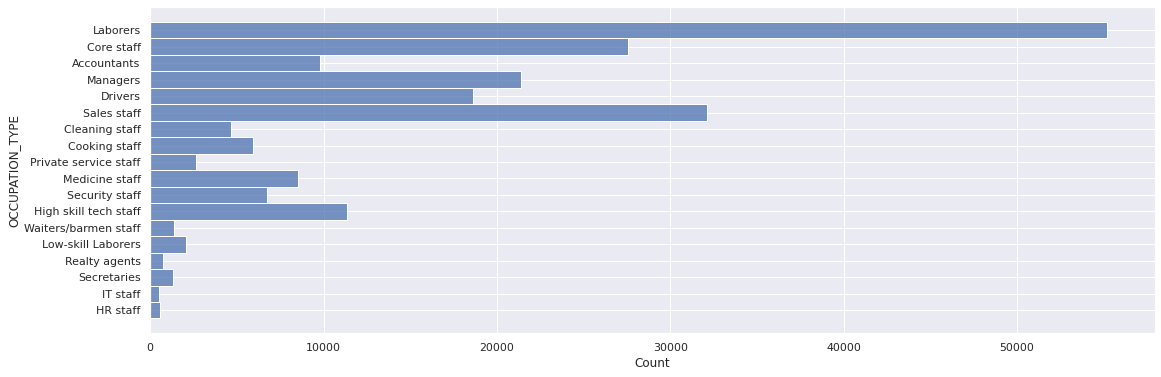

In [17]:
sns.histplot(y=df_train["OCCUPATION_TYPE"])

4- Plot the family status of the applicants

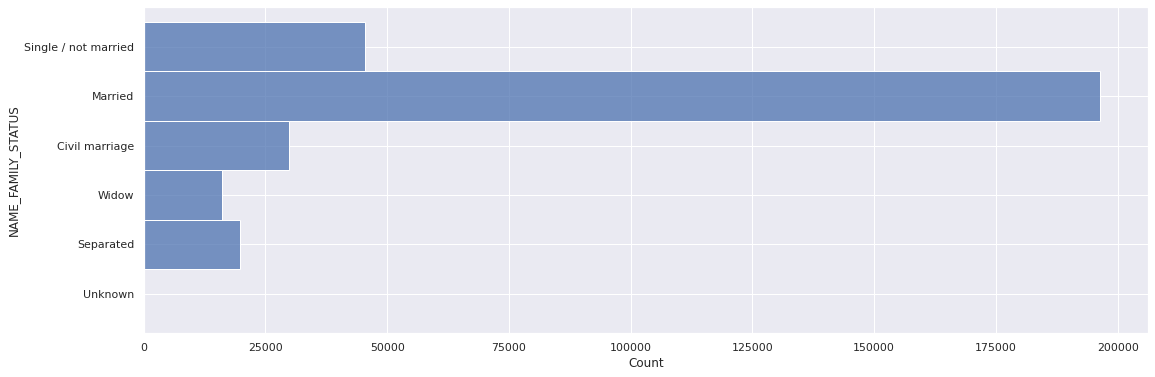

In [18]:
sns.histplot(y=df_train["NAME_FAMILY_STATUS"])

5- Plot the income type of applicants grouped by the target variable

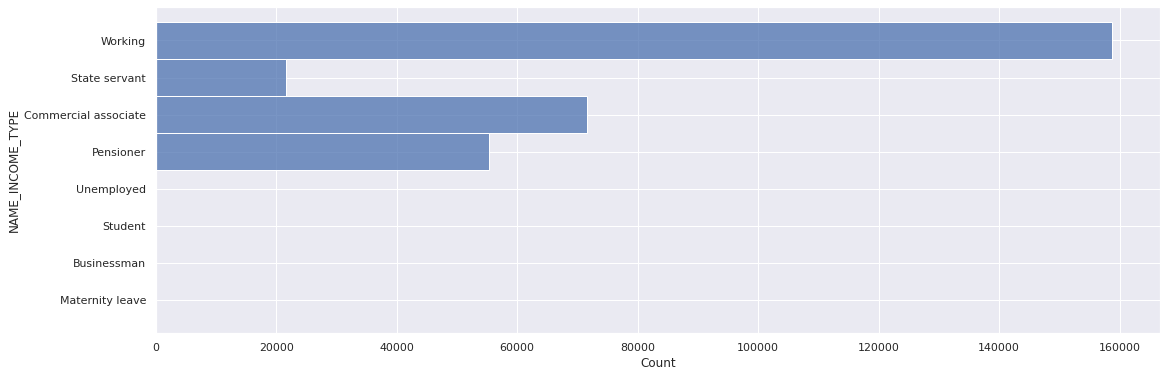

In [19]:
sns.histplot(y=df_train["NAME_INCOME_TYPE"])

## Preprocessing

In this section, you will code a function to make all the data pre processing for the dataset. What you have to deliver is a function that takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

Keep in mind that you could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. You should align train and test to have the same number of columns

In [20]:
def feat_split(data):
### This function split the features by 4 types: categorical, flag, numeric and binary.
### It only returns a list of columns for each type, to use them as masks for the dataset.

  cat_feat = []
  for col in data:
      if (data[col].dtype == "object") & (len(data[col].unique()) > 2):
          cat_feat.append(col)
  
  flag_feat = []
  for col in data:
    if (data[col].dtype == "object") & (len(data[col].unique()) == 2):
      flag_feat.append(col)

  num_feat = []
  for col in data:
      if ((data[col].dtype == "int") or (data[col].dtype == "float")) & (len(data[col].unique()) > 2):
          num_feat.append(col)

  bin_feat = []
  for col in data:
      if ((data[col].dtype == "int") or (data[col].dtype == "float")) & (len(df_train[col].unique()) == 2):
          bin_feat.append(col)

  return cat_feat, flag_feat, num_feat, bin_feat

In [21]:
### This column as a repeated anomalous value (the highest one) wich we're gonna replace by NaN
df_train["DAYS_EMPLOYED"] = df_train["DAYS_EMPLOYED"].replace(df_train["DAYS_EMPLOYED"].max(), np.nan)
df_test["DAYS_EMPLOYED"] = df_test["DAYS_EMPLOYED"].replace(df_test["DAYS_EMPLOYED"].max(), np.nan)

In [22]:
### Checking possible outliers in numerical features:
outliers_check = []
cat_feat, flag_feat, num_feat, bin_feat = feat_split(feat_train)

for col in num_feat:
  zscore = stats.zscore(feat_train[col])
  if zscore.max() > 2: ### As Z-score for the anomalous value in the DAYS_EMPLOYED column is a bit higher then 2, we take 2 as treshold reference.
    outliers_check.append(col)

outliers_check ### Those are the columns to check for outliers

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'HOUR_APPR_PROCESS_START']

The CODE_GENDER column in the train dataset present a few XNA values. Let's just assume that means: Not Applicable.

In [23]:
def feat_imput(train, test, cat_feat, flag_feat, num_feat, bin_feat):
### This function imput diferent types of columns (from the feat_split function return)
### using 2 diferent strategy: median and most_frequent
### It applies on the same dataset required as argument

  imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
  imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

  train[num_feat] = imp_median.fit_transform(train[num_feat])
  test[num_feat] = imp_median.transform(test[num_feat])
  
  feat = cat_feat + flag_feat + bin_feat
  train[feat] = imp_mode.fit_transform(train[feat])
  test[feat] = imp_mode.transform(test[feat])

  return train, test

In [24]:
def feat_encode(train, test, cat_feat, flag_feat):
### This function encode using OneHotEncoder
### for cat_feat (#labels > 2) and flag_feat (#labels = 2).
### In this last case, droping one column
### by setting the drop parameter in "if_binary"

  encoder = OneHotEncoder(sparse=False, drop="if_binary")
  feat = cat_feat + flag_feat

  enc_train = encoder.fit_transform(train[feat])
  enc_train = pd.DataFrame(data=enc_train, columns=encoder.get_feature_names_out(), index=train.index)
  train = pd.concat([train, enc_train], axis=1)
  train = train.drop(columns=feat)

  enc_test = encoder.transform(test[feat])
  enc_test = pd.DataFrame(data=enc_test, columns=encoder.get_feature_names_out(), index=test.index)
  test = pd.concat([test, enc_test], axis=1)
  test = test.drop(columns=feat)

  return train, test

In [25]:
def feat_scaling(train, test, num_feat, scaler):
### This function scales numerical features
### from both train and test dataset

  train[num_feat] = scaler.fit_transform(train[num_feat])
  test[num_feat] = scaler.transform(test[num_feat])

  return train, test

In [26]:
def feat_preprocessing(train, test):
### This function goes trough the whole preprocessing at once
### MAKE SURE:
### 1) Drop SK_ID_CURR column from both train and test dataset
### 2) Drop TARGET column from the train dataset

  cat_feat, flag_feat, num_feat, bin_feat = feat_split(train)

  train, test = feat_imput(train, test, cat_feat, flag_feat, num_feat, bin_feat)

  train, test = feat_encode(train, test, cat_feat, flag_feat)
  
  train, test = feat_scaling(train, test, num_feat, StandardScaler())

  return train, test

In [27]:
feat_train = df_train.drop(["SK_ID_CURR", "TARGET"], axis=1)
feat_test = df_test.drop("SK_ID_CURR", axis=1)

train_pp, test_pp = feat_preprocessing(feat_train, feat_test)

## Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

1- Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter 

In [28]:
baseline_LR = LogisticRegression(random_state=100, C=0.1, max_iter=1000).fit(train_pp, df_train["TARGET"])

2- Use the trained model to predict probabilites for the test data, and then save the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities. REMEMBER: the TARGET columns should ONLY contain the probabilities that the debt is not repaid (equivalent to the class 1).

In [29]:
def kaggle_submission(name: str, test, model):
### This function export the model prediction probabilities to .csv file
### in the Kaggle submission format

  y_proba = model.predict_proba(test)[:, 1]
  sub = df_test[["SK_ID_CURR"]]
  sub["TARGET"] = y_proba
  sub.to_csv(f"/content/drive/MyDrive/Colab Notebooks/AnyoneAI - Sprint 3/Project/{name}.csv", index=False)

In [30]:
kaggle_submission("baselineLR", test_pp, baseline_LR)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


3- Go to the Kaggle competition, and in the [submissions page](https://www.kaggle.com/competitions/home-credit-default-risk/submit) load your csv file. Report here the result in the private score you obtained.

At this point, the model should produce a result around 0.67 

Kaggle score: 0.73941

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

1- Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [31]:
RFC = RandomForestClassifier(random_state=100, n_jobs=-1).fit(train_pp, df_train["TARGET"])

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [32]:
kaggle_submission("RFC", test_pp, RFC)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


3- Load the predictions to the competition. Report the private score here.

Kaggle score: 0.69988

### Randomized Search with Cross Validation

> 



So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


1- Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc".

In [33]:
hyperparameter_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 50, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200]
}

In [34]:
RFC_RScv = RandomizedSearchCV(RandomForestClassifier(), hyperparameter_grid, n_iter=2, random_state=100, cv=2, scoring="roc_auc", n_jobs=-1)
RFC_RScv.fit(train_pp, df_train["TARGET"])

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   random_state=100, scoring='roc_auc')

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [35]:
kaggle_submission("RFC_RScv", test_pp, RFC_RScv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


3- Load the predictions to the competition. Report the private score here.

Kaggle score: 0.71853

4- If you have the time and resources, you can train the model for longer iterations, or select more estimator sizes. This is optional, but if you, we would love to see your results.

### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [37]:
def Light_GBM(train, target, test, parameters):
  lgb_train = lgb.Dataset(train.values, target.values)
  LightGBM = lgb.train(parameters, lgb_train)

  y_pred = LightGBM.predict(test.values)  
  sub = df_test["SK_ID_CURR"]
  sub["TARGET"] = y_pred
  sub.to_csv(f"/content/drive/MyDrive/Colab Notebooks/AnyoneAI - Sprint 3/Project/LGBM.csv", index=False)

In [38]:
parameters = {
    "objective": "binary", 
    "metric": "auc", 
    "verbosity": -1, 
    "seed": 1,
    "random_state": 43
    }

Light_GBM(train_pp, df_train["TARGET"], test_pp, parameters)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Kaggle score: 0.74280

### Optional: Using Scikit Learn Pipelines 

So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.